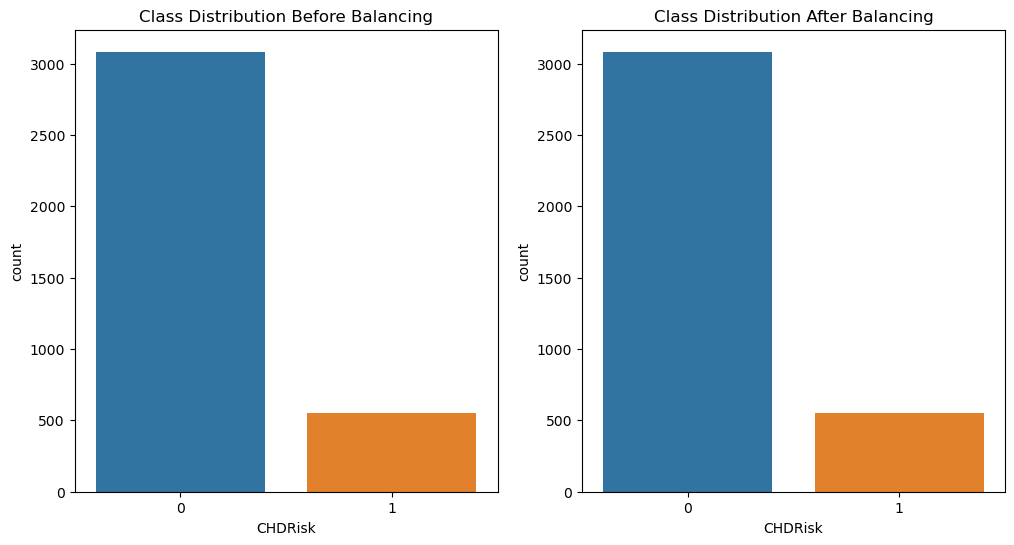

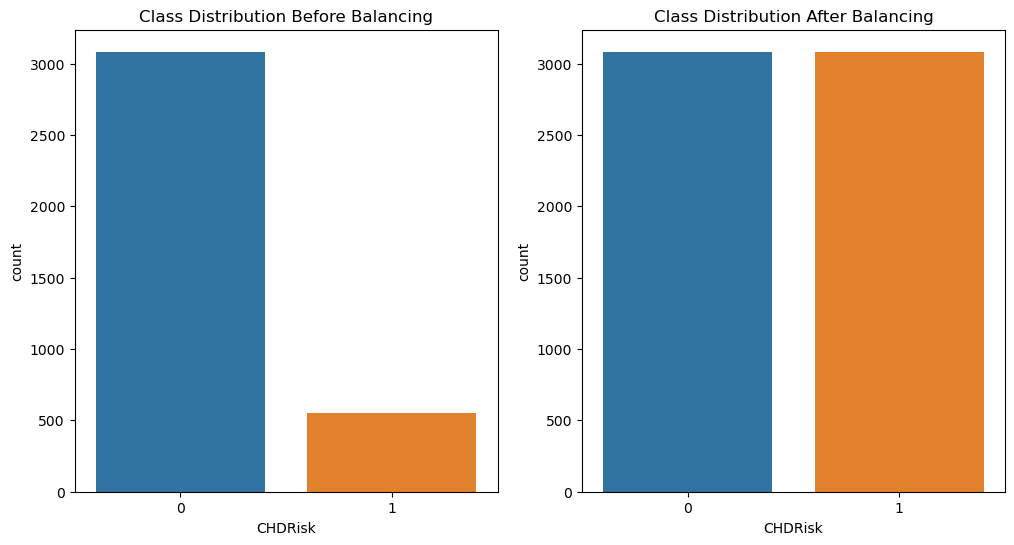

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,725,46
Actual 1,9,762


Accuracy Score : 0.9643320363164721
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       771
           1       0.94      0.99      0.97       771

    accuracy                           0.96      1542
   macro avg       0.97      0.96      0.96      1542
weighted avg       0.97      0.96      0.96      1542



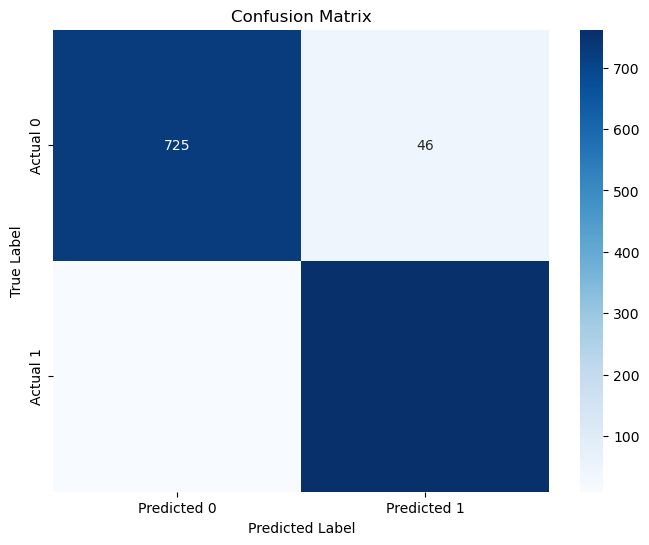

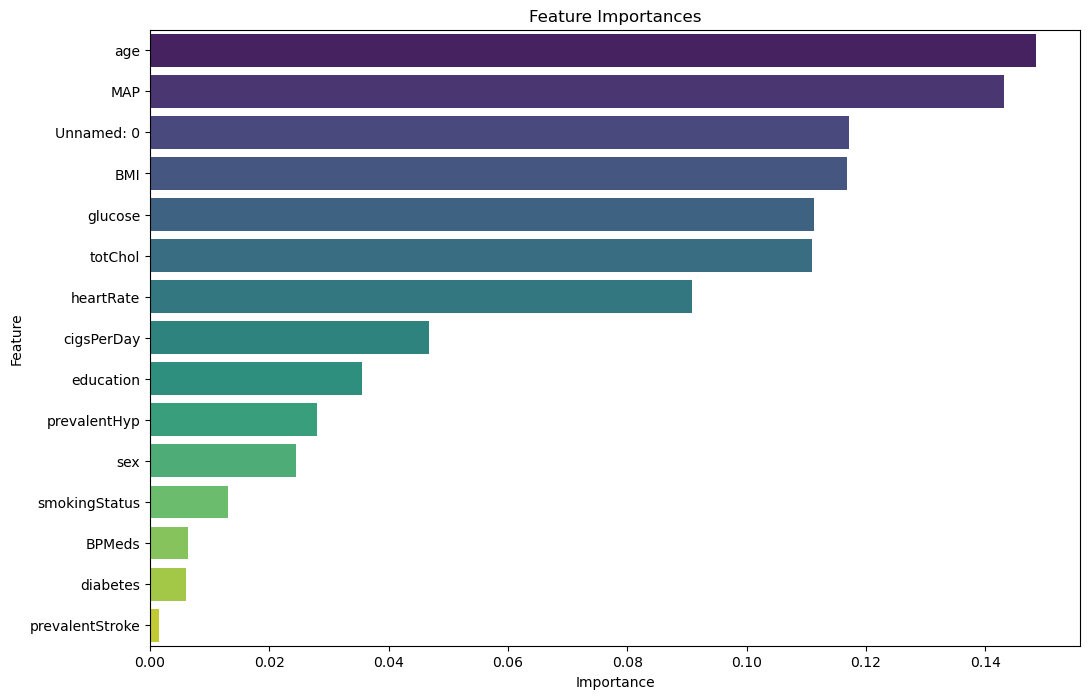

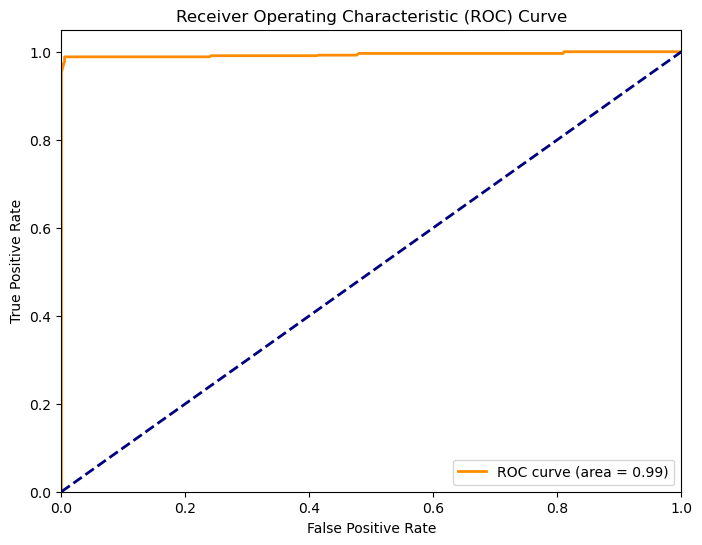

Cross-validation results (accuracy): [0.97163695 0.97001621 0.96839546 0.96836983 0.97972425]
Mean cross-validation accuracy: 0.9716285403694458
Standard deviation of cross-validation accuracy: 0.004224031036334012


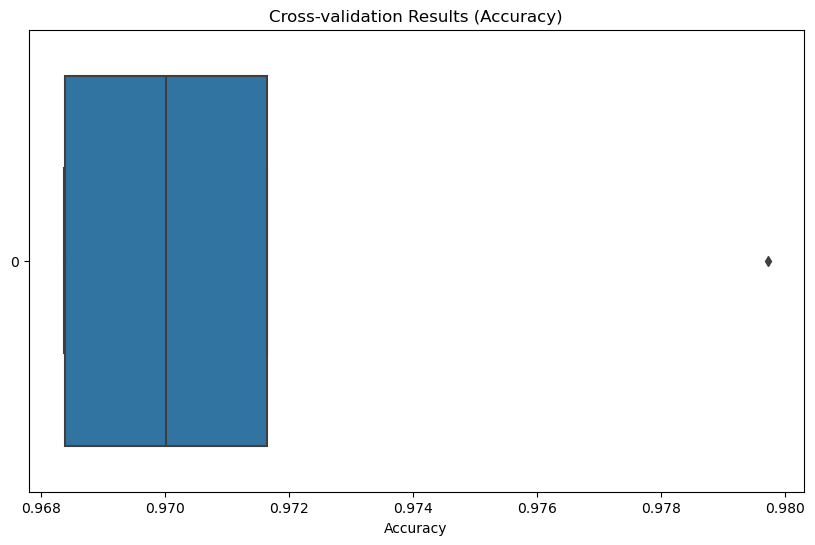

Model saved to rf_model.pkl


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import pickle

def load_data(file_path):
    return pd.read_csv(file_path)

def preprocess_data(df, target_column):
    y = df[target_column]
    X = df.drop(columns=target_column)
    return X, y

def balance_data(X, y):
    ros = RandomOverSampler(random_state=1)
    return ros.fit_resample(X, y)

def split_and_scale(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
    scaler = StandardScaler().fit(X_train)
    return scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, scaler

def train_model(X_train, y_train):
    rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
    return rf_model.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    acc_score = accuracy_score(y_test, predictions)
    clf_report = classification_report(y_test, predictions)
    return predictions, cm, acc_score, clf_report

def plot_class_distribution(y_before, y_after):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.countplot(x=y_before, ax=ax[0])
    ax[0].set_title('Class Distribution Before Balancing')
    sns.countplot(x=y_after, ax=ax[1])
    ax[1].set_title('Class Distribution After Balancing')
    plt.show()

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_feature_importances(importances, feature_names):
    importances_df = pd.DataFrame(sorted(zip(importances, feature_names), reverse=True), columns=['Importance', 'Feature'])
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')
    plt.title('Feature Importances')
    plt.show()

def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_cv_results(cv_results):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=cv_results, orient='h')
    plt.title('Cross-validation Results (Accuracy)')
    plt.xlabel('Accuracy')
    plt.show()

def main():
    file_path = Path('cleaned_data.csv')
    df = load_data(file_path)
    X, y = preprocess_data(df, 'CHDRisk')
    plot_class_distribution(y, y)  # Before balancing
    X_resampled, y_resampled = balance_data(X, y)
    plot_class_distribution(y, y_resampled)  # After balancing
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = split_and_scale(X_resampled, y_resampled)
    rf_model = train_model(X_train_scaled, y_train)
    predictions, cm, acc_score, clf_report = evaluate_model(rf_model, X_test_scaled, y_test)
    
    print("Confusion Matrix")
    display(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(clf_report)
    
    plot_confusion_matrix(cm)
    plot_feature_importances(rf_model.feature_importances_, X.columns)
    
    # ROC Curve
    y_pred_proba = rf_model.predict_proba(X_test_scaled)
    plot_roc_curve(y_test, y_pred_proba)
    
    # K-fold cross-validation
    k = 5
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    X_resampled_scaled = scaler.fit_transform(X_resampled)
    cv_results = cross_val_score(rf_model, X_resampled_scaled, y_resampled, cv=kf, scoring='accuracy')
    
    print(f'Cross-validation results (accuracy): {cv_results}')
    print(f'Mean cross-validation accuracy: {cv_results.mean()}')
    print(f'Standard deviation of cross-validation accuracy: {cv_results.std()}')
    
    plot_cv_results(cv_results)
    
    # Saving the model
    pickle_file = "rf_model.pkl"
    with open(pickle_file, 'wb') as file:
        pickle.dump(rf_model, file)
    print(f"Model saved to {pickle_file}")

if __name__ == "__main__":
    main()
